# Case 1. Template
**Neural Networks for Machine Learning Applications**<br>
20.01.2022<br>
G10 Lauri.M & Jesse.J<br>
https://github.com/lauriom/AnacondaML <br>
Metropolia University of Applied Sciences

## 1. Introduction

The purpose of this notebook is to create a neural network to predict hearth attacks based on kaggle survey data

## 2. Setup

The following libraries and functions were used

In [1]:
%pylab inline
import time
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, losses, metrics, optimizers
from sklearn.utils import resample

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'seaborn version: {sns.__version__}')

Populating the interactive namespace from numpy and matplotlib
tensorflow version: 2.7.0
pandas version: 1.3.5
seaborn version: 0.11.2


## 3. Dataset

In [2]:
file = "http://users.metropolia.fi/~jessejy/NeuralNetwork/heart_disease_health_indicators_BRFSS2015.csv"
#csv downloaded to Jesses metropolia webpage
df = pd.read_csv(file, na_values = '?', on_bad_lines='skip')

In [3]:
#onehotting variables added 2% accuracy
#onehot diabetes types
holder = pd.DataFrame(tf.one_hot(df['Diabetes'], 3).numpy(), columns = ['no Diab', 'type1 Diab', 'type2 Diab'])
del df['Diabetes']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

#onehot GenHlth
holder = pd.DataFrame(tf.one_hot(df['GenHlth'], 5).numpy(), columns = ['bad', 'poor', 'satisfactory', "good", "excelent"])
del df['GenHlth']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

#onehot income
holder = pd.DataFrame(tf.one_hot(df['Income'], 8).numpy(), columns = ['I1', 'I2', 'I3', "I4", "I5", "I6", "I7", "I8"])
del df['Income']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

#onehot education
holder = pd.DataFrame(tf.one_hot(df['Education'], 6).numpy(), columns = ['E1', 'E2', 'E3', "E4", "E5", "E6"])
del df['Education']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

#onehot physHealt
holder = pd.DataFrame(tf.one_hot(df['PhysHlth'], 30).numpy(), columns = (['H' + str(x) for x in range(1,31)]))
del df['PhysHlth']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

#onehot physHealth
holder = pd.DataFrame(tf.one_hot(df['MentHlth'], 30).numpy(), columns = (['M' + str(x) for x in range(1,31)]))
del df['MentHlth']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

df.tail()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,PhysActivity,Fruits,Veggies,...,M21,M22,M23,M24,M25,M26,M27,M28,M29,M30
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253679,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Preprocessing

In [4]:
# Balancing the data

df_majority = df[df['HeartDiseaseorAttack'] == 0.0]
df_minority = df[df['HeartDiseaseorAttack'] == 1.0]
print(df_majority.shape)

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=24000,    # to match average class
                                 random_state=42) # reproducible results

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=24000,     # to match average class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority_downsampled, df_minority_upsampled])
print(df_upsampled['HeartDiseaseorAttack'].value_counts())

#Define the dependent variable that needs to be predicted (labels)

labels = df_upsampled['HeartDiseaseorAttack']
features = df_upsampled.drop('HeartDiseaseorAttack', axis = 1)
features.fillna(0, inplace = True)

(229787, 98)
0.0    24000
1.0    24000
Name: HeartDiseaseorAttack, dtype: int64


In [5]:
from numpy import shape


labels = 1.0*(labels > 0)
# 70 15 15 trait test validation split, test val split done later
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=1)
shape(train_features), shape(test_features)

((33600, 97), (14400, 97))

## 5. Modeling

In [6]:
from keras import regularizers

normalize = layers.Normalization()
normalize.adapt(train_features)

def make_model():
    model = models.Sequential([
        normalize,
        layers.Dense(98, activation = 'relu'), # 98 is the ammount of onehotted variables
        layers.Dropout(0.2), #Dropout is to correct overfitting
        layers.Dense(98, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(98, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(98, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(98, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile(
        optimizer = optimizers.RMSprop(),
        loss = losses.BinaryCrossentropy(),
        metrics = metrics.BinaryAccuracy(name = 'acc')
    )

    return model

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 97)               195       
 n)                                                              
                                                                 
 dense (Dense)               (None, 98)                9604      
                                                                 
 dropout (Dropout)           (None, 98)                0         
                                                                 
 dense_1 (Dense)             (None, 98)                9702      
                                                                 
 dropout_1 (Dropout)         (None, 98)                0         
                                                                 
 dense_2 (Dense)             (None, 98)                9702      
                                                        

## 6. Training

In [7]:
# With 20 epochs and batch size 128 the models fitting is prety quick at 12.96 seconds (approximate depends on computer power)
EPOCHS = 100

t0 = time.time()
r = model.fit(
    train_features,
    train_labels,
    validation_split=0.5,
    epochs = EPOCHS,
    batch_size = 128,
    verbose = 0,
    )

t1 = time.time()
etime = t1 - t0
print(f'Total elapsed time {etime:.2f} s and {etime/EPOCHS:.3f} s/epoch')

Total elapsed time 100.23 s and 1.002 s/epoch


## 7. Performance and evaluation

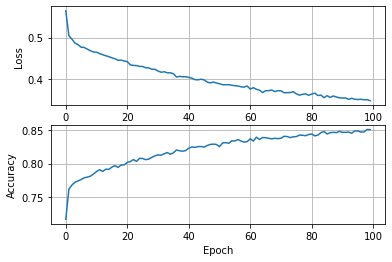

In [8]:
# Plots for loss and accuracy
from matplotlib.pyplot import subplot, plot, grid, ylabel, xlabel, show

epochs = r.epoch
loss = r.history['loss']
acc = r.history['acc']

subplot(2, 1, 1)
plot(epochs, loss)
grid()
ylabel('Loss')

subplot(2, 1, 2)
plot(epochs, acc)
grid()
ylabel('Accuracy')
xlabel('Epoch')
show()

In [9]:
# Training loss and accuracy
print(f'Training loss = {loss[-1]:.3f}')
print(f'Training accuracy = {acc[-1]:.3f}')

Training loss = 0.347
Training accuracy = 0.851


In [10]:
# Confusion matrix without in plain text format
predictions = model.predict(train_features)
pred_labels = 1.0*(predictions >= 0.5)
cm = confusion_matrix(train_labels, pred_labels)
print(cm)

[[13858  2912]
 [ 2617 14213]]


<AxesSubplot:>

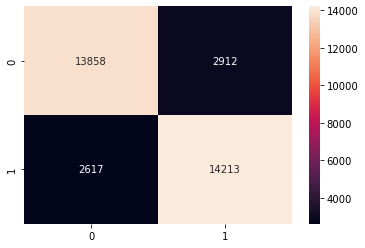

In [11]:
# Confusion matrix with heatmap
cm = confusion_matrix(train_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='.0f')

In [12]:
cr = classification_report(train_labels, pred_labels, target_names = ['Healthy', 'Disease'])
print(cr)

              precision    recall  f1-score   support

     Healthy       0.84      0.83      0.83     16770
     Disease       0.83      0.84      0.84     16830

    accuracy                           0.84     33600
   macro avg       0.84      0.84      0.84     33600
weighted avg       0.84      0.84      0.84     33600



In [13]:
# Overall precision of model 
tn, fp, fn, tp = confusion_matrix(train_labels, pred_labels).ravel()
print(f'Precision for Healthy = {tn/(tn+fn):.2f}')
print(f'Precision for Disease = {tp/(fp+tp):.2f}')

Precision for Healthy = 0.84
Precision for Disease = 0.83


## 8. Discussion and conclusions

Overall the model is pretty accurate taking in factor it being a inquiry based data. Loss is pretty high and that may be because of the inquiry based data.

Making standard changes to the model such as increasing neurons & layers didnt seem to help predictions at all.
First big brakethrough was balancing the data. We tried using weights on the model but didnt get any noticable results by that. We tested the resample method and that elevated the accuracy from 98%/24% (overall about 50%-60% precision) to the 79%/73% accuracy (overall about 77% precision). We manged to lift it to 81%/75% (overall 79% precision) with minor tweeks of the model.

Second breakthrough came with the one hotting. There was about 7 variables that we needed to categorialize with one hot encoding. It took us a while but we got it working and it raised accuracy on both healthy and disease with 2% points. That meant our overall precision is about 81% for this model.

After one-hotting the training labels from 28 to 98 increasing the layers and neurons seemed to help the accuracy by alot. We doubled the layers and increased the epochs to 1000, the accuracy jumped to 88/82 (Overall 85%). The loss curve indicated that there is still more room for improvement but, due to large training time (1 sec per epoch, 16 min in total) we didn't feel like keeping current or increasing the layer or epoch count anymore would be fruitful for the purposes of submitting the exersize.

For the submission purposes we chose 100 epochs with 84/83 (83.5% total) accuracy. If you wish to test the large epoch count you can increase the EPOCH variable in TRAINING field. Training takes around 1 sec per epoch on Ryzen 5800u CPU